The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# Funções de Pontuação de Atenção
:label:`sec_attention-scoring-functions`


Em :numref:`sec_nadaraya-waston`,
usamos um kernel gaussiano para modelar
interações entre consultas e chaves.
Tratando o expoente do kernel gaussiano
em :eqref:`eq_nadaraya-waston-gaussian` como uma *função de pontuação de atenção* (ou *função de pontuação* para abreviar),
os resultados desta função foram
essencialmente alimentados em
uma operação softmax.
Como resultado,
Nós obtivemos
uma distribuição de probabilidade (pesos de atenção)
sobre valores que estão emparelhados com chaves.
No fim,
a saída do *pooling* de atenção
é simplesmente uma soma ponderada dos valores
com base nesses pesos de atenção.

Em alto nível,
podemos usar o algoritmo acima
para instanciar a estrutura de mecanismos de atenção
em :numref:`fig_qkv`.
Denotando uma função de pontuação de atenção por $a$,
:numref:`fig_attention_output`
ilustra como a saída do *pooling* de atenção
pode ser calculado como uma soma ponderada de valores.
Uma vez que os pesos de atenção são
uma distribuição de probabilidade,
a soma ponderada é essencialmente
uma média ponderada.

![Calculando a saída do *pooling* de atenção como uma média ponderada de valores.](../img/attention-output.svg)
:label:`fig_attention_output`



Matematicamente,
suponha que temos
uma consulta $\mathbf{q} \in \mathbb{R}^q$
e $m$ pares de valores-chave $(\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)$, onde qualquer $\mathbf{k}_i \in \mathbb{R}^k$ e qualquer $\mathbf{v}_i \in \mathbb{R}^v$.
O *pooling* de atenção $f$
é instanciado como uma soma ponderada dos valores:

$$f(\mathbf{q}, (\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)) = \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i \in \mathbb{R}^v,$$
:eqlabel:`eq_attn-pooling`

Onde
o peso da atenção (escalar) para a consulta $\mathbf{q}$
e a chave $\mathbf{k}_i$
é calculado pela operação softmax de
uma função de pontuação de atenção $a$ que mapeia dois vetores para um escalar:

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_{j=1}^m \exp(a(\mathbf{q}, \mathbf{k}_j))} \in \mathbb{R}.$$
:eqlabel:`eq_attn-scoring-alpha`

Como podemos ver,
diferentes escolhas da função de pontuação de atenção $a$
levam a diferentes comportamentos de concentração de atenção.
Nesta secção,
apresentamos duas funções populares de pontuação
que usaremos para desenvolver mais
mecanismos sofisticados de atenção posteriormente.


In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

## Operação *Softmax* Mascarada

Como acabamos de mencionar,
uma operação softmax é usada para
produzir uma distribuição de probabilidade como pesos de atenção.
Em alguns casos,
nem todos os valores devem ser incluídos no agrupamento de atenção.
Por exemplo,
para processamento eficiente de minibatch em :numref:`sec_machine_translation`,
algumas sequências de texto são preenchidas com
tokens especiais que não possuem significado.
Para obter um *pooling* de atenção
sobre
apenas tokens significativos como valores,
podemos especificar um comprimento de sequência válido (em número de tokens)
para filtrar aqueles que estão além deste intervalo especificado
ao calcular softmax.
Desta maneira,
podemos implementar tal *operação de softmax mascarada*
na seguinte função `masked_softmax`,
onde qualquer valor além do comprimento válido
é mascarado como zero.


In [2]:
#@save
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # `X`: 3D tensor, `valid_lens`: 1D or 2D tensor
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

Para demonstrar como essa função funciona,
considere um minibatch de dois exemplos de matriz $2 \times 4$,
onde os comprimentos válidos para esses dois exemplos
são dois e três, respectivamente.
Como resultado da operação mascarada softmax,
valores além dos comprimentos válidos
são todos mascarados como zero.


In [3]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.3520, 0.6480, 0.0000, 0.0000],
         [0.5525, 0.4475, 0.0000, 0.0000]],

        [[0.2764, 0.4460, 0.2776, 0.0000],
         [0.3825, 0.3849, 0.2327, 0.0000]]])

Da mesma forma, também podemos
use um tensor bidimensional
para especificar comprimentos válidos
para cada linha em cada exemplo de matriz.


In [4]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4436, 0.2773, 0.2791, 0.0000]],

        [[0.4437, 0.5563, 0.0000, 0.0000],
         [0.2422, 0.3533, 0.2061, 0.1984]]])

## Atenção Aditiva
:label:`subsec_additive-attention`

Em geral,
quando as consultas e as chaves são vetores de comprimentos diferentes,
podemos usar atenção aditiva
como a função de pontuação.
Dada uma consulta  $\mathbf{q} \in \mathbb{R}^q$
e uma chave \mathbf{k} \in \mathbb{R}^k$,
a função de pontuação *atenção aditiva*

$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$
:eqlabel:`eq_additive-attn`

onde
parâmetros aprendíveis
$\mathbf W_q\in\mathbb R^{h\times q}$, $\mathbf W_k\in\mathbb R^{h\times k}$, e $\mathbf w_v\in\mathbb R^{h}$.
Equivalente a :eqref:`eq_additive-attn`,
a consulta e a chave são concatenadas
e alimentado em um MLP com uma única camada oculta
cujo número de unidades ocultas é $h$, um hiperparâmetro.
Usando $\tanh$ como a função de ativação e desativando
termos de *bias*,
implementamos atenção aditiva a seguir.


In [5]:
#@save
class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of `queries`: (`batch_size`, no. of
        # queries, 1, `num_hiddens`) and shape of `keys`: (`batch_size`, 1,
        # no. of key-value pairs, `num_hiddens`). Sum them up with
        # broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of `self.w_v`, so we remove the last
        # one-dimensional entry from the shape. Shape of `scores`:
        # (`batch_size`, no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of `values`: (`batch_size`, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

Vamos demonstrar a classe `AdditiveAttention` acima
com um exemplo de brinquedo,
onde formas (tamanho do lote, número de etapas ou comprimento da sequência em tokens, tamanho da *feature*)
de consultas, chaves e valores
são ($2$, $1$, $20$), ($2$, $10$, $2$),
e ($2$, $10$, $4$), respectivamente.
A saída de concentração de atenção
tem uma forma de (tamanho do lote, número de etapas para consultas, tamanho do *feature* para valores).


In [6]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# The two value matrices in the `values` minibatch are identical
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

Embora a atenção aditiva contenha parâmetros que podem ser aprendidos,
uma vez que cada chave é a mesma neste exemplo,
os pesos de atenção são uniformes,
determinados pelos comprimentos válidos especificados.


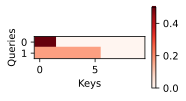

In [7]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## Atenção de Produto Escalar em Escala

Um design mais eficiente do ponto de vista computacional para a função de pontuação pode ser simplesmente o produto escalar.
No entanto, a operação de produto escalar requer que a consulta e a chave tenham o mesmo comprimento de vetor, digamos $d$.
Suponha que todos os elementos da consulta e a chave sejam variáveis aleatórias independentes com média zero e variância unitária.
O produto escalar de ambos os vetores tem média zero e variância de $d$.
Para garantir que a variação do produto escalar ainda permaneça um, independentemente do comprimento do vetor, a  função de pontuação de *atenção ao produto escalar em escala*


$$a(\mathbf q, \mathbf k) = \mathbf{q}^\top \mathbf{k}  /\sqrt{d}$$

divide o produto escalar por $\sqrt{d}$.
Na prática, geralmente pensamos em minibatches para eficiência, como computação de atenção para $n$ consultas e $m$ pares de valor-chave, onde consultas e chaves têm comprimento $d$ e os valores têm comprimento $v$.
A atenção do produto escalar das consultas $\mathbf Q\in\mathbb R^{n\times d}$, chaves $\mathbf K\in\mathbb R^{m\times d}$, e valores $\mathbf V\in\mathbb R^{m\times v}$ é


$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.$$
:eqlabel:`eq_softmax_QK_V`

Na implementação a seguir da atenção ao produto escalar, usamos o *dropout* para regularização do modelo.


In [8]:
#@save
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # Shape of `queries`: (`batch_size`, no. of queries, `d`)
    # Shape of `keys`: (`batch_size`, no. of key-value pairs, `d`)
    # Shape of `values`: (`batch_size`, no. of key-value pairs, value
    # dimension)
    # Shape of `valid_lens`: (`batch_size`,) or (`batch_size`, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Set `transpose_b=True` to swap the last two dimensions of `keys`
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

Para demonstrar a classe `DotProductAttention` acima,
usamos as mesmas chaves, valores e comprimentos válidos do exemplo de brinquedo anterior
para atenção aditiva.
Para a operação de produto escalar,
fazemos o tamanho da *feature* de consultas
o mesmo que o das chaves.


In [9]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

Da mesma forma que na demonstração de atenção aditiva,
uma vez que `keys` contém o mesmo elemento
que não pode ser diferenciado por nenhuma consulta,
pesos uniformes de atenção são obtidos.


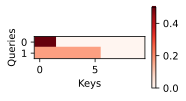

In [10]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## Resumo

* Podemos calcular a saída do *pooling* de atenção como uma média ponderada de valores, onde diferentes escolhas da função de pontuação de atenção levam a diferentes comportamentos de agrupamento de atenção.
* Quando consultas e chaves são vetores de comprimentos diferentes, podemos usar a função de pontuação de atenção aditiva. Quando são iguais, a função de pontuação de atenção do produto escalonado é mais eficiente do ponto de vista computacional.



## Exercícios

1. Modifique as chaves no exemplo do brinquedo e visualize o peso da atenção. A atenção aditiva e a atenção de produto escalar em escala ainda geram os mesmos pesos de atenção? Por que ou por que não?
1. Usando apenas multiplicações de matrizes, você pode projetar uma nova função de pontuação para consultas e chaves com diferentes comprimentos de vetor?
1. Quando as consultas e as chaves têm o mesmo comprimento de vetor, a soma de vetores é um design melhor do que o produto escalar para a função de pontuação? Por que ou por que não?


[Discussions](https://discuss.d2l.ai/t/1064)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTE1NzE4Mjc0MjgsLTcyOTI5NDA2MF19
-->
